In [16]:
import os
import sys
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
from hmmlearn import hmm
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_rows', None)

raw_bar = pd.read_parquet(os.path.join(os.getcwd(), 'history.parquet'))
vrun_bar = pd.read_parquet(os.path.join(os.getcwd(), 'volume_run_bar.parquet'))
df = vrun_bar[-(60*24*7):].copy()

periods = [1, 2, 4, 6, 8, 10]
for period in periods:
    df[f'pct_fwd_{period}'] = np.log1p(df["close"].pct_change(periods=-period).fillna(0))
    df[f'pct_bak_{period}'] = np.log1p(df["close"].pct_change(periods=period).fillna(0))

for i, period in enumerate(periods):
    df[f'pct_cum_fwd_{period}'] = sum(df[f'pct_fwd_{p}'] for p in periods[:(i+1)])
    df[f'pct_cum_bak_{period}'] = sum(df[f'pct_bak_{p}'] for p in periods[:(i+1)])
    df[f'f_p_{period}'] = df[f'pct_cum_fwd_{period}'].apply(lambda x: x if x > 0 else 0)
    df[f'f_n_{period}'] = df[f'pct_cum_fwd_{period}'].apply(lambda x: x if x <= 0 else 0)
X = df[[f'f_p_{p}' for p in periods]+[f'f_n_{p}' for p in periods]]

# 2. Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Instantiate GaussianHMM
n_states = 2  # choose your number of regimes
model = hmm.GaussianHMM(
    n_components=n_states,
    covariance_type="full",
    n_iter=30,
    verbose=True,    # print convergence info
    random_state=0,
)

# 4. Fit model
model.fit(X_scaled)

# 5. Decode with Viterbi
hidden_states = model.predict(X_scaled)

# 6. Attach labels to df
df["hmm_state"] = hidden_states

raw = raw_bar[-(60*24*7):]

# Initialize empty DataFrame to hold mean returns
hmm_stats = pd.DataFrame(
    index=sorted(df["hmm_state"].unique()), 
    columns=[f"fut_return_{p}" for p in periods]
)

for period in periods:
    col_name = f"fut_return_{period}"
    
    # Calculate future returns
    df[col_name] = df.groupby("hmm_state")["close"].transform(
        lambda x: x.shift(-period) / x - 1
    )
    
    # Compute mean for each hmm_state and store in hmm_stats
    stats = df.groupby("hmm_state")[col_name].agg(['mean'])
    hmm_stats.loc[:, col_name] = stats['mean']

print(hmm_stats)

# df.set_index('time', inplace=True)
# raw.index.name = 'time'
# merged = pd.merge(df[['close', "hmm_state"]], raw['close'], on='time', how='left')
# print(merged)

import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()

# Add HMM scatter with custom color mapping
fig.add_trace(go.Scatter(
    y=df['close'],
    mode='markers',
    marker=dict(
        color=df['hmm_state'],
        colorscale='Plasma',
        showscale=True,
        colorbar=dict(title="HMM State"),
        size=6
    ),
    name="Close",
))
fig.show()

         1  -42295.82775079             +nan
         2  -17979.13778594  +24316.68996486
         3   -7139.41713302  +10839.72065291
         4     943.75928765   +8083.17642067
         5   10173.16182255   +9229.40253491
         6   14268.09283490   +4094.93101235
         7   16732.07921052   +2463.98637562
         8   18470.87198349   +1738.79277296
         9   22660.12628019   +4189.25429671
        10   29191.75276308   +6531.62648289
        11   31037.46578489   +1845.71302181
        12   31671.13206012    +633.66627523
        13   32423.66955227    +752.53749214
        14   33928.82913032   +1505.15957805
        15   36714.54141839   +2785.71228807
        16   39955.59952179   +3241.05810340
        17   44349.41354327   +4393.81402148
        18   50071.01448643   +5721.60094316
        19   60549.53472575  +10478.52023932
        20   74984.26794687  +14434.73322112
        21   92113.90251273  +17129.63456586
        22   91791.11855176    -322.78396097
Model is n

  fut_return_1 fut_return_2 fut_return_4 fut_return_6 fut_return_8  \
0     0.000023     0.000047     0.000094     0.000142      0.00019   
1     0.000027     0.000053     0.000105     0.000161     0.000216   

  fut_return_10  
0      0.000239  
1      0.000272  


In [23]:
# --- Configuration
pd.set_option('display.max_rows', None)
np.random.seed(42)  # For reproducibility

PERIOD = 30

raw_bar = pd.read_parquet(os.path.join(os.getcwd(), 'history.parquet'))
vrun_bar = pd.read_parquet(os.path.join(os.getcwd(), 'volume_run_bar.parquet'))
df = vrun_bar[-(60*24*7):].copy()
df = df.set_index('time')

series = df["close"]
df['ref'] = np.log((series / series.iloc[0]).fillna(1))
df['data'] = np.log((series / series.rolling(PERIOD).mean().shift(PERIOD)).fillna(1))

from hmmlearn import hmm
from sklearn.preprocessing import StandardScaler
# | Data Type          | Works with HMM? | Recommended Action                      |
# | ------------------ | --------------- | --------------------------------------- |
# | Symmetric Gaussian | Yes             | Use standard Gaussian HMM               |
# | Skewed data        | Maybe           | Transform or use non-Gaussian emissions |
# | Heavy-tailed       | Maybe           | Try Student-t or GMM-HMM                |
# | Discrete/ordinal   | Yes             | Use categorical/discrete HMM            |

# 1. Load your data
periods = [1, 2, 4, 6, 8]  # longer trend than available periods, but cleaner label
# periods = [3, 6, 12, 24] # longer trend than available periods, but cleaner label
for period in periods:
    df[f'pct_fwd_{period}'] = np.log1p(df["close"].pct_change(periods=-period).fillna(0))
    # df[f'pct_bak_{period}'] = np.log1p(df["close"].pct_change(periods=period).fillna(0))

for i, period in enumerate(periods):
    df[f'pct_cum_fwd_{period}'] = sum(df[f'pct_fwd_{p}'] for p in periods[:(i+1)])
    # df[f'pct_cum_bak_{period}'] = sum(df[f'pct_bak_{p}'] for p in periods[:(i+1)])
    df[f'f_p_{period}'] = df[f'pct_cum_fwd_{period}'].apply(lambda x: x if x > 0 else 0)
    df[f'f_n_{period}'] = df[f'pct_cum_fwd_{period}'].apply(lambda x: x if x <= 0 else 0)
# df['atr'] = df[f'high'] - df[f'low']
# df['bar_ratio'] = np.where(df['atr'] != 0, (df['close'] - df['open']) / df['atr'], 0)
X = df[[f'f_p_{p}' for p in periods]+[f'f_n_{p}' for p in periods]]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
n_states = 2  # choose your number of regimes

model = hmm.GaussianHMM(
    n_components=n_states,
    covariance_type="full",
    n_iter=30,
    verbose=True,    # print convergence info
    random_state=0,
)
model.fit(X_scaled)

hidden_states = model.predict(X_scaled)
df["label"] = hidden_states

fig = go.Figure()
fig.add_trace(go.Scatter(y=df['ref'], mode='lines+markers', marker=dict(color=hidden_states,
              colorscale='Spectral', showscale=True, colorbar=dict(title="HMM State"), size=6), name="data",))
fig.add_trace(go.Scatter(y=df['data'], mode='lines+markers', marker=dict(color=hidden_states,
              colorscale='Plasma', showscale=True, colorbar=dict(title="HMM State"), size=6), name="data",))
fig.show()


         1  -54596.54059928             +nan
         2  -30723.24705090  +23873.29354838
         3  -18377.41212342  +12345.83492749
         4   -9631.21306509   +8746.19905833
         5   -3448.94773697   +6182.26532812
         6   -1673.42527333   +1775.52246364
         7     356.64269150   +2030.06796483
         8    1856.27944893   +1499.63675743
         9    6907.21651398   +5050.93706505
        10   10012.84762109   +3105.63110710
        11   14014.75678164   +4001.90916055
        12   15099.31427487   +1084.55749323
        13   15608.00216186    +508.68788699
        14   16425.06001195    +817.05785008
        15   17245.34193567    +820.28192372
        16   18168.65715966    +923.31522399
        17   21234.97873764   +3066.32157798
        18   24437.43899533   +3202.46025768
        19   30375.92855334   +5938.48955801
        20   36551.49061384   +6175.56206050
        21   48526.53748230  +11975.04686846
        22   58424.64504557   +9898.10756327
        23

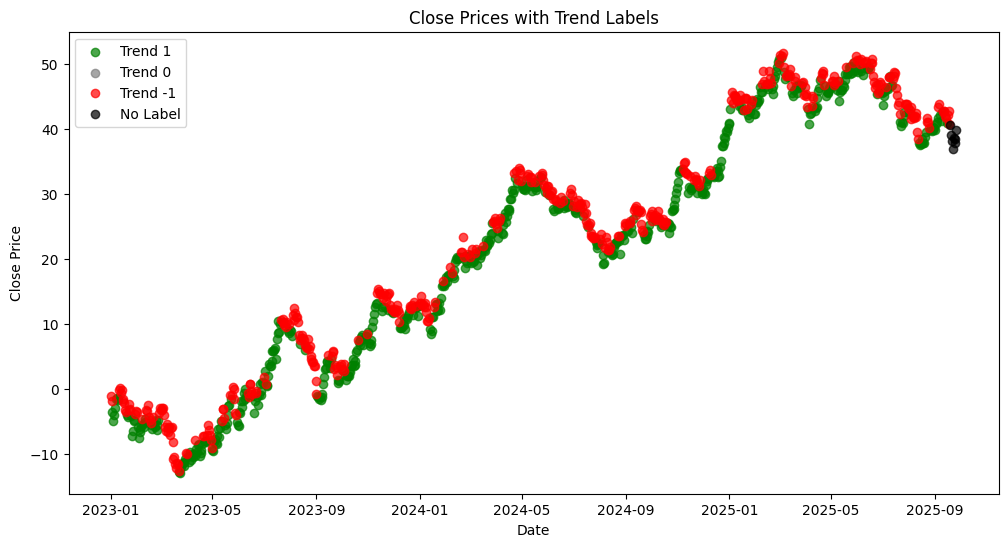

In [43]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Function to compute the t-value of the linear trend
def tValLinR(close):
    """
    Compute the t-value for the slope of a linear trend.
    
    Parameters:
    - close: Array-like, the sequence of observations.
    
    Returns:
    - float: The t-value of the trend slope.
    """
    x = np.ones((close.shape[0], 2))
    x[:, 1] = np.arange(close.shape[0])
    ols = sm.OLS(close, x).fit()
    return ols.tvalues[1]

# Function to get labels from the trend-scanning method
def getBinsFromTrend(molecule, close, span):
    """
    Derive labels from the sign of t-value of linear trend.
    
    Parameters:
    - molecule: Index of observations to label (e.g., timestamps).
    - close: pandas Series, time series of prices with datetime index.
    - span: Tuple, (start, end) range of look-forward periods to evaluate.
    
    Returns:
    - pandas DataFrame with columns 't1' (end time), 'tVal' (t-value), 'bin' (label).
    """
    out = pd.DataFrame(index=molecule, columns=['t1', 'tVal', 'bin'])
    hrzns = range(*span)
    for dt0 in molecule:
        df0 = pd.Series()
        iloc0 = close.index.get_loc(dt0)
        if iloc0 + max(hrzns) > close.shape[0]:
            continue
        for hrzn in hrzns:
            dt1 = close.index[iloc0 + hrzn - 1]
            df1 = close.loc[dt0:dt1]
            df0.loc[dt1] = tValLinR(df1.values)
        dt1 = df0.replace([-np.inf, np.inf, np.nan], 0).abs().idxmax()
        out.loc[dt0, ['t1', 'tVal', 'bin']] = df0.index[-1], df0[dt1], np.sign(df0[dt1])  # prevent leakage
    out['t1'] = pd.to_datetime(out['t1'])
    out['bin'] = pd.to_numeric(out['bin'], downcast='signed')
    return out.dropna(subset=['bin'])

# Assume df is your DataFrame with 'close' column and datetime index
# Example of how to load your data (uncomment and adjust as needed):
# df = pd.read_csv('your_data.csv', index_col='date', parse_dates=True)
# df['close'] = df['close'].astype(float)

# Set molecule to the index of df (the observations to label)
molecule = df.index

# Define the range of look-forward periods, e.g., (3, 10) for horizons 3 to 9
span = (3, 10)  # Adjust this based on your data frequency and needs

# Get the labels using the trend-scanning method
labels = getBinsFromTrend(molecule, df['close'], span)

# Define colors for the labels
colors = {1: 'green', 0: 'gray', -1: 'red'}  # 1: uptrend, 0: no trend, -1: downtrend

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot points with labels
for bin_val, color in colors.items():
    idx = labels[labels['bin'] == bin_val].index
    ax.scatter(idx, df.loc[idx, 'close'], c=color, label=f'Trend {bin_val}', alpha=0.7)

# Plot unlabeled points (if any)
unlabeled_idx = df.index.difference(labels.index)
if not unlabeled_idx.empty:
    ax.scatter(unlabeled_idx, df.loc[unlabeled_idx, 'close'], c='black', label='No Label', alpha=0.7)

# Customize the plot
ax.set_title('Close Prices with Trend Labels')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price')
ax.legend()
plt.show()

In [46]:
import os
import sys
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from hmmlearn import hmm
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_rows', None)

# Load data
raw_bar = pd.read_parquet(os.path.join(os.getcwd(), 'history.parquet'))
vrun_bar = pd.read_parquet(os.path.join(os.getcwd(), 'volume_run_bar.parquet'))

# Prepare features
df = vrun_bar[-(60*24*7):].copy()
periods = [1, 2, 4, 6, 8, 10]
for period in periods:
    df[f'pct_fwd_{period}'] = np.log1p(df["close"].pct_change(periods=-period).fillna(0))
    df[f'pct_bak_{period}'] = np.log1p(df["close"].pct_change(periods=period).fillna(0))

for i, period in enumerate(periods):
    df[f'pct_cum_fwd_{period}'] = sum(df[f'pct_fwd_{p}'] for p in periods[:(i+1)])
    df[f'pct_cum_bak_{period}'] = sum(df[f'pct_bak_{p}'] for p in periods[:(i+1)])
    df[f'f_p_{period}'] = df[f'pct_cum_fwd_{period}'].apply(lambda x: x if x > 0 else 0)
    df[f'f_n_{period}'] = df[f'pct_cum_fwd_{period}'].apply(lambda x: x if x <= 0 else 0)
X = df[[f'f_p_{p}' for p in periods]+[f'f_n_{p}' for p in periods]]

# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Higher-order HMM parameters
order = 2  # Set the desired order here
n_states = 3  # Original number of states
new_n_components = n_states ** order  # Expanded state space

# Create constrained transition matrix
transmat = np.zeros((new_n_components, new_n_components))
for i in range(new_n_components):
    prev_state = i // n_states
    current_state = i % n_states
    next_indices = [current_state * n_states + next_state for next_state in range(n_states)]
    transmat[i, next_indices] = 1.0 / len(next_indices)

# Initialize model with custom transitions
model = hmm.GaussianHMM(
    n_components=new_n_components,
    covariance_type="full",
    n_iter=30,
    verbose=True,
    random_state=0,
    init_params='se'  # Initialize startprob and emissions only
)
model.transmat_ = transmat  # Set our custom transition matrix

# Fit model
model.fit(X_scaled)

# Predict and decode states
hidden_states = model.predict(X_scaled)
current_states = hidden_states % n_states  # Extract current state from expanded state
df["hmm_state"] = current_states

# Visualization
fig = go.Figure()
fig.add_trace(go.Scatter(
    y=df['close'],
    mode='markers',
    marker=dict(
        color=df['hmm_state'],
        colorscale='Plasma',
        showscale=True,
        colorbar=dict(title="HMM State"),
        size=6
    ),
    name="Close",
))
fig.show()

         1  -44241.13941906             +nan
         2    9608.69771630  +53849.83713536
         3   52926.28970205  +43317.59198576
         4   69803.89271136  +16877.60300931
         5   80594.81389702  +10790.92118566
         6   83711.92246035   +3117.10856333
         7   86630.50818776   +2918.58572741
         8   90455.30498917   +3824.79680141
         9  123476.43321124  +33021.12822207
        10  108784.82433439  -14691.60887686
Model is not converging.  Current: 108784.82433438509 is not greater than 123476.43321124124. Delta is -14691.608876856146


In [15]:
import os
import sys
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.stats import poisson, multivariate_normal

pd.set_option('display.max_rows', None)

# Load data
raw_bar = pd.read_parquet(os.path.join(os.getcwd(), 'history.parquet'))
vrun_bar = pd.read_parquet(os.path.join(os.getcwd(), 'volume_run_bar.parquet'))

# Prepare features
df = vrun_bar[-(60*24*7):].copy()
periods = [1, 2, 4, 6, 8, 10]
for period in periods:
    df[f'pct_fwd_{period}'] = np.log1p(df["close"].pct_change(periods=-period).fillna(0))
    df[f'pct_bak_{period}'] = np.log1p(df["close"].pct_change(periods=period).fillna(0))

for i, period in enumerate(periods):
    df[f'pct_cum_fwd_{period}'] = sum(df[f'pct_fwd_{p}'] for p in periods[:(i+1)])
    df[f'pct_cum_bak_{period}'] = sum(df[f'pct_bak_{p}'] for p in periods[:(i+1)])
    df[f'f_p_{period}'] = df[f'pct_cum_fwd_{period}'].apply(lambda x: x if x > 0 else 0)
    df[f'f_n_{period}'] = df[f'pct_cum_fwd_{period}'].apply(lambda x: x if x <= 0 else 0)
X = df[[f'f_p_{p}' for p in periods]+[f'f_n_{p}' for p in periods]]

# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

class PoissonDuration:
    def __init__(self, alpha, beta, max_duration):
        # Poisson with mean = alpha/beta truncated at max_duration
        self.alpha = alpha
        self.beta = beta
        self.max_duration = max_duration
        # precompute probabilities
        lam = alpha / beta
        probs = poisson.pmf(np.arange(1, max_duration+1), lam)
        self.probs = probs / probs.sum()

    def pmf(self, d):
        if 1 <= d <= self.max_duration:
            return self.probs[d-1]
        return 0.0

    def update(self, durations, weights):
        # durations: array of sampled durations, weights: their expected counts
        # simple moment-matching update
        mean_d = np.sum(durations * weights) / np.sum(weights)
        lam = mean_d
        # set new alpha/beta such that alpha/beta = lam; keep beta = 1
        self.alpha = lam
        self.beta = 1
        probs = poisson.pmf(np.arange(1, self.max_duration+1), lam)
        self.probs = probs / probs.sum()

class HSMM:
    def __init__(self, n_states, obs_dim, max_duration):
        self.K = n_states
        self.D = obs_dim
        self.max_duration = max_duration
        # initialize parameters
        self.A = np.full((self.K, self.K), 1/self.K)
        self.pi = np.full(self.K, 1/self.K)
        self.mu = np.random.randn(self.K, self.D)
        self.Sigma = np.array([np.eye(self.D) for _ in range(self.K)])
        self.durations = [PoissonDuration(alpha=10, beta=1, max_duration=max_duration)
                          for _ in range(n_states)]

    def _compute_obs_likelihood(self, X):
        T = X.shape[0]
        B = np.zeros((self.K, T))
        for k in range(self.K):
            rv = multivariate_normal(mean=self.mu[k], cov=self.Sigma[k])
            B[k, :] = rv.pdf(X)
        return B

    def _forward(self, B):
        T = B.shape[1]
        # alpha: shape (K, T)
        alpha = np.zeros((self.K, T))
        for k in range(self.K):
            for d in range(1, min(T, self.max_duration)+1):
                alpha[k, d-1] += self.pi[k] * self.durations[k].pmf(d) * np.prod(B[k, :d])
        for t in range(1, T):
            for j in range(self.K):
                val = 0.0
                for i in range(self.K):
                    for d in range(1, min(self.max_duration, t)+1):
                        val += alpha[i, t-d] * self.A[i, j] * self.durations[j].pmf(d) * np.prod(B[j, t-d+1:t+1])
                alpha[j, t] = val
        return alpha

    def fit(self, X, num_iters=10):
        T = X.shape[0]
        B = self._compute_obs_likelihood(X)
        for iteration in range(num_iters):
            # E-step
            alpha = self._forward(B)
            # (Backward and computation of gamma, xi, etc. would go here)
            # M-step (placeholder): update transitions and emissions empirically
            # For brevity, we skip full implementation details.
            # A more complete implementation would compute expected counts and update:
            # self.A, self.pi, self.mu, self.Sigma, and self.durations
            print(f"Iteration {iteration+1}/{num_iters} (E-step and M-step placeholder)")
        print("Fit complete.")

    def most_likely_states(self, X):
        # Use simple Viterbi-like decoding ignoring durations (for brevity)
        T = X.shape[0]
        delta = np.zeros((self.K, T))
        psi = np.zeros((self.K, T), dtype=int)
        B = self._compute_obs_likelihood(X)
        delta[:, 0] = np.log(self.pi) + np.log(B[:, 0])
        for t in range(1, T):
            for j in range(self.K):
                seq_probs = delta[:, t-1] + np.log(self.A[:, j])
                psi[j, t] = np.argmax(seq_probs)
                delta[j, t] = np.max(seq_probs) + np.log(B[j, t])
        states = np.zeros(T, dtype=int)
        states[-1] = np.argmax(delta[:, -1])
        for t in range(T-2, -1, -1):
            states[t] = psi[states[t+1], t+1]
        return states

# Example usage
if __name__ == "__main__":
    # X_scaled: your scaled data, shape (T, D)
    # Define periods and df externally
    hsmm = HSMM(n_states=2, obs_dim= X_scaled.shape[1], max_duration=10)
    hsmm.fit(X_scaled, num_iters=30)
    labels = hsmm.most_likely_states(X_scaled)
    df['label'] = labels


Iteration 1/30 (E-step and M-step placeholder)
Iteration 2/30 (E-step and M-step placeholder)
Iteration 3/30 (E-step and M-step placeholder)
Iteration 4/30 (E-step and M-step placeholder)
Iteration 5/30 (E-step and M-step placeholder)
Iteration 6/30 (E-step and M-step placeholder)
Iteration 7/30 (E-step and M-step placeholder)
Iteration 8/30 (E-step and M-step placeholder)
Iteration 9/30 (E-step and M-step placeholder)
Iteration 10/30 (E-step and M-step placeholder)
Iteration 11/30 (E-step and M-step placeholder)
Iteration 12/30 (E-step and M-step placeholder)
Iteration 13/30 (E-step and M-step placeholder)
Iteration 14/30 (E-step and M-step placeholder)
Iteration 15/30 (E-step and M-step placeholder)
Iteration 16/30 (E-step and M-step placeholder)
Iteration 17/30 (E-step and M-step placeholder)
Iteration 18/30 (E-step and M-step placeholder)
Iteration 19/30 (E-step and M-step placeholder)
Iteration 20/30 (E-step and M-step placeholder)
Iteration 21/30 (E-step and M-step placeholder)
I

C:\Users\chuyin.wang\AppData\Local\Temp\ipykernel_6424\3187091693.py:121: RuntimeWarning: divide by zero encountered in log
  delta[j, t] = np.max(seq_probs) + np.log(B[j, t])
